## 1. Inicialización del entorno

In [1]:
from dotenv import load_dotenv
import logging
import json
from typing import Any, Dict, List
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display import Image

from typing import TypedDict
from langchain.prompts import ChatPromptTemplate
from langchain.chat_models import init_chat_model
from langgraph.graph import StateGraph, START, END

load_dotenv()
logging.basicConfig(level=logging.WARNING)


### Constantes

Parametrización:

In [2]:
CONLUSIONS_N_PHRASES = 10
MAX_RETRIES = 3

Valores de prueba:

In [3]:
user_query = 'Muéstrame los 10 productos más vendidos para el B2B en el último trimestre, excluyendo los Accesorios. Mes a mes indica cuántas unidades se vendieron, y muestra también a qué categoría y subcategoría pertenecen'

query_results = [{'producto': 'Camiseta clásica, P', 'categoria': 'Prenda', 'subcategoria': 'Camiseta', 'primer_mes': 381, 'segundo_mes': 380, 'tercer_mes': 190, 'total': 951},
  {'producto': 'Jersey clásico de manga corta, SG', 'categoria': 'Prenda', 'subcategoria': 'Jersey', 'primer_mes': 329, 'segundo_mes': 299, 'tercer_mes': 183, 'total': 811},
  {'producto': "Women's Mountain Shorts, S", 'categoria': 'Prenda', 'subcategoria': 'Pantalones cortos', 'primer_mes': 295, 'segundo_mes': 258, 'tercer_mes': 141, 'total': 694},
  {'producto': 'Jersey con logotipo de manga larga, G', 'categoria': 'Prenda', 'subcategoria': 'Jersey', 'primer_mes': 312, 'segundo_mes': 243, 'tercer_mes': 129, 'total': 684},
  {'producto': 'AWC Logo Cap', 'categoria': 'Prenda', 'subcategoria': 'Gorra', 'primer_mes': 291, 'segundo_mes': 243, 'tercer_mes': 121, 'total': 655},
  {'producto': "Women's Mountain Shorts, L", 'categoria': 'Prenda', 'subcategoria': 'Pantalones cortos', 'primer_mes': 262, 'segundo_mes': 236, 'tercer_mes': 120, 'total': 618},
  {'producto': 'Jersey clásico de manga corta, G', 'categoria': 'Prenda', 'subcategoria': 'Jersey', 'primer_mes': 217, 'segundo_mes': 231, 'tercer_mes': 113, 'total': 561},
  {'producto': 'Calcetines para carreras, G', 'categoria': 'Prenda', 'subcategoria': 'Calcetines', 'primer_mes': 231, 'segundo_mes': 179, 'tercer_mes': 93, 'total': 503},
  {'producto': 'Camiseta clásica, M', 'categoria': 'Prenda', 'subcategoria': 'Camiseta', 'primer_mes': 197, 'segundo_mes': 187, 'tercer_mes': 85, 'total': 469},
  {'producto': 'Half-Finger Gloves, M', 'categoria': 'Prenda', 'subcategoria': 'Guantes', 'primer_mes': 187, 'segundo_mes': 168, 'tercer_mes': 82, 'total': 437}]

sql_query = "WITH \nlast_quarter AS (\n  SELECT\n    fs.product_key,\n    COALESCE(dp.spanish_product_name, dp.english_product_name) AS product_name,\n    dp.spanish_product_category_name,\n    dp.spanish_product_subcategory_name,\n    EXTRACT(MONTH FROM fs.order_date) AS month_in_quarter,\n    fs.order_quantity\n  FROM\n    sales.fact_sales fs\n    JOIN sales.dim_product dp ON fs.product_key = dp.product_key\n  WHERE\n    fs.sale_source = 'reseller_sales'\n    AND dp.spanish_product_category_name <> 'Accesorio'\n    AND fs.order_date >= date_trunc('quarter', CURRENT_DATE - interval '3 months')\n    AND fs.order_date < date_trunc('quarter', CURRENT_DATE)\n),\ntop_products AS (\n  SELECT\n    product_key,\n    product_name,\n    spanish_product_category_name,\n    spanish_product_subcategory_name,\n    SUM(order_quantity) AS total_qty\n  FROM\n    last_quarter\n  GROUP BY\n    product_key, product_name, spanish_product_category_name, spanish_product_subcategory_name\n  ORDER BY\n    total_qty DESC\n  LIMIT 10\n)\nSELECT\n  tp.product_name AS producto,\n  tp.spanish_product_category_name AS categoria,\n  tp.spanish_product_subcategory_name AS subcategoria,\n  SUM(lq.order_quantity) FILTER (WHERE lq.month_in_quarter = EXTRACT(MONTH FROM date_trunc('quarter', CURRENT_DATE - interval '3 months'))) AS primer_mes,\n  SUM(lq.order_quantity) FILTER (WHERE lq.month_in_quarter = EXTRACT(MONTH FROM date_trunc('quarter', CURRENT_DATE - interval '3 months') + interval '1 month')) AS segundo_mes,\n  SUM(lq.order_quantity) FILTER (WHERE lq.month_in_quarter = EXTRACT(MONTH FROM date_trunc('quarter', CURRENT_DATE - interval '3 months') + interval '2 month')) AS tercer_mes,\n  SUM(lq.order_quantity) AS total\nFROM\n  top_products tp\n  LEFT JOIN last_quarter lq ON tp.product_key = lq.product_key\nGROUP BY\n  tp.product_name, tp.spanish_product_category_name, tp.spanish_product_subcategory_name\nORDER BY\n  total DESC;"

## 2. Configuración del Modelo a utilizar

In [4]:
llm_generator = init_chat_model(
    model_provider= 'azure_openai',
    model= 'gpt-4o',
    temperature= 0.10,
)

llm_graphics_generator = init_chat_model(
    model_provider= 'azure_openai',
    model= 'gpt-4.1-mini',
    temperature= 0.75,
)

## 3. Definición del Estado

In [5]:
class ConclusionsGeneratorState(TypedDict):
    user_query: str
    sql_query: str
    language: str
    query_results: str
    graphs_retries: int
    nl_output: str
    sql_explanation: str
    graphics_json: str

class ConclusionsGeneratorOutputState(TypedDict):
    nl_output: str
    sql_explanation: str
    graphics_json: str

## 4. Funciones Auxiliares

Función que permite convertir una lista de diccionarios a tabla Markdown.

In [6]:
def convert_to_markdown_table(data: List[Dict[str, Any]]) -> str:
    """
    Converts a list of dictionaries into a Markdown table string.

    Args:
        data: A list of dictionaries, where each dictionary represents a row
                and keys are column headers.

    Returns:
        A string representing the data as a Markdown table.
        Returns an empty string if the input list is empty.
    """
    if not data:
        return ""

    # Get column headers from the keys of the first dictionary
    headers = list(data[0].keys())

    # Create the Markdown header row
    header_row = "| " + " | ".join(headers) + " |"

    # Create the separator row for Markdown
    separator_row = "|---" * len(headers) + "|"

    # Create the data rows
    data_rows = []
    for row in data:
        # Get values for each row in the same order as headers
        values = [str(row.get(header, '')) for header in headers]
        data_row = "| " + " | ".join(values) + " |"
        data_rows.append(data_row)

    # Combine all parts into the final Markdown table string
    return "\n".join([header_row, separator_row] + data_rows)


Función que permite recrear gráficos de Plotly a partir de un JSON generado por un LLM.

In [7]:
def create_dashboard_from_json(
        json_str: str,
        height: int = 900,
        width: int = 1600,
    ) -> None | go.Figure:
    """
    Procesa un JSON de gráficos y crea un dashboard interactivo de Plotly.

    Args:
        json_str: Una cadena JSON válida que contiene el título del dashboard
                y una lista de diccionarios de Plotly.
        height: Alto total del conjunto de gráficos.
        width: Ancho total del conjunto de gráficos.
    """
    logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

    try:
        data = json.loads(json_str)
        main_title = data.get('dashboard_title', 'Dashboard de Análisis')
        json_graphs = data.get('charts', [])
    except json.JSONDecodeError as e:
        logging.error(f"Error al decodificar el JSON: {e}")
        return None

    if not json_graphs:
        logging.info("No hay datos de gráficos para procesar. Saliendo.")
        return None

    subplot_titles = []
    specs = []
    row_specs = []

    for graph in json_graphs:
        title_obj = graph['layout'].get('title', "Sin Título")
        if isinstance(title_obj, dict):
            title = title_obj.get('text', "Sin Título")
        else:
            title = title_obj
        subplot_titles.append(title)
        
        graph_data = graph['data']
        if isinstance(graph_data, dict):
            graph_data = [graph_data]
            
        is_domain_chart = graph_data[0]['type'] in ['pie', 'funnelarea', 'sunburst', 'treemap']
        row_specs.append({"type": "domain"} if is_domain_chart else {"type": "xy"})
        
        if len(row_specs) == 2:
            specs.append(row_specs)
            row_specs = []
    
    if len(specs) < 2 and len(json_graphs) > 2:
        while len(specs) < 2:
            specs.append([{}, {}])
    
    if len(specs) == 0:
        specs = [[{}, {}], [{}, {}]]

    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=subplot_titles,
        specs=specs
    )

    row = 1
    col = 1
    for i, graph in enumerate(json_graphs):
        graph_data = graph['data']
        if isinstance(graph_data, dict):
            graph_data = [graph_data]
        
        for trace_dict in graph_data:
            trace_type = trace_dict.get('type')

            if trace_type == 'pie':
                fig.add_trace(go.Pie(trace_dict), row=row, col=col)
                break  # <--- Agrega break aquí
            elif trace_type == 'bar':
                fig.add_trace(go.Bar(trace_dict), row=row, col=col)
                break  # <--- Agrega break aquí
            elif trace_type == 'scatter':
                fig.add_trace(go.Scatter(trace_dict), row=row, col=col)
                break  # <--- Agrega break aquí
            elif trace_type == 'line':
                fig.add_trace(go.Scatter(trace_dict), row=row, col=col)
                break  # <--- Agrega break aquí
            elif trace_type == 'heatmap':
                fig.add_trace(go.Heatmap(trace_dict), row=row, col=col)
                break  # <--- Agrega break aquí
            elif trace_type == 'histogram':
                fig.add_trace(go.Histogram(trace_dict), row=row, col=col)
                break  # <--- Agrega break aquí
            else:
                logging.warning(f"Tipo de gráfico desconocido: '{trace_type}'. Omitiendo traza en la posición ({row},{col}).")
                

        subplot_layout = graph.get('layout', {})
        
        xaxis_title = subplot_layout.get('xaxis', {}).get('title', {})
        if isinstance(xaxis_title, dict):
            xaxis_title_text = xaxis_title.get('text')
        else:
            xaxis_title_text = xaxis_title
            
        yaxis_title = subplot_layout.get('yaxis', {}).get('title', {})
        if isinstance(yaxis_title, dict):
            yaxis_title_text = yaxis_title.get('text')
        else:
            yaxis_title_text = yaxis_title
            
        fig.update_xaxes(title_text=xaxis_title_text, row=row, col=col)
        fig.update_yaxes(title_text=yaxis_title_text, row=row, col=col)
        
        col += 1
        if col > 2:
            col = 1
            row += 1
            
    fig.update_layout(
        height= height,
        width= width,
        autosize= True,
        title_text= main_title,
        title_x= 0.5,
        font=dict(
            family= "Arial, sans-serif",
            size= 12
        ),
        paper_bgcolor="#f2f2f2",
        plot_bgcolor="#ffffff",
        margin=dict(l=50, r=50, t=80, b=50),
    )

    return fig


## 5. Definición de Agentes

### NL Conclusions Generator

In [8]:
nl_conclusions_prompt = ChatPromptTemplate.from_messages([{
    "role": "system",
    "content": (
        "Eres un analista experto en el dominio de la base de datos consultada."
        "\n\nLa consulta realizada por un usuario de negocio es:"
        "\n\n{user_query}"
        "\n\nLa salida en texto plano (markdown) de la consulta SQL ejecutada es:"
        "\n\n{query_results}"
        "\n\n\nTu tarea es extraer las conclusiones principales de los datos, redactadas de "
        "forma breve y directa, sin explicaciones innecesarias ni contexto adicional."
        "\nDirígete a un usuario de negocio con conocimientos en el tema, "
        "por lo que no es necesario definir conceptos básicos."
        "\nMáximo {n_phrases} frases concisas pero, usando terminología técnica del dominio cuando corresponda."
        "\nNo incluyas datos sin relevancia ni interpretaciones especulativas."
        "\nLa respuesta debe estar en el siguiente idioma: {language}"
    )
}])

nl_conclusions_generator = nl_conclusions_prompt | llm_generator

print(
    nl_conclusions_generator.invoke({
        'user_query': user_query,
        'query_results': convert_to_markdown_table(query_results),
        'n_phrases': 10,
        'language': 'Spanish'
    }).content
)


1. La "Camiseta clásica, P" lidera las ventas con 951 unidades en el trimestre, destacándose como el producto más vendido.  
2. Los jerseys son la subcategoría más recurrente en el top 10, con tres productos entre los más vendidos.  
3. Los "Women's Mountain Shorts" aparecen en dos tallas diferentes (S y L), acumulando 1,312 unidades vendidas en conjunto.  
4. La categoría "Prenda" domina completamente el ranking, sin presencia de otras categorías.  
5. Los accesorios fueron correctamente excluidos, pero los guantes y calcetines, clasificados como prendas, están presentes en el listado.  
6. El primer mes del trimestre muestra consistentemente mayores ventas en todos los productos del top 10.  
7. La subcategoría "Camiseta" ocupa dos posiciones en el ranking, con un total combinado de 1,420 unidades vendidas.  
8. El "Jersey clásico de manga corta, SG" y el "Jersey con logotipo de manga larga, G" juntos suman 1,495 unidades, consolidando la subcategoría Jersey.  
9. Los "Calcetines par

### NL SQL Explanaitor

In [9]:
nl_sql_explanaition_prompt = ChatPromptTemplate.from_messages([{
    "role": "system",
    "content": (
        "Eres un analista de datos experimentado, especialista en el dominio de negocio "
        "relacionado con la base de datos que se te consulta. Tu tarea es analizar la "
        "consulta SQL ejecutada y explicar la lógica que subyace a la misma, para que "
        "un usuario de negocio pueda entender cómo se llegó a la respuesta a su pregunta."
        "\n\nLa consulta del usuario de negocio es:"
        "\n\n{user_query}"
        "\n\nLa consulta SQL que se ejecutó para responderla es:"
        "\n\n{sql_query}"
        "\n\n\nTu respuesta debe ser un análisis conciso y directo, sin jerga innecesaria. "
        "Dirígete al usuario como si estuvieras explicando tu proceso de pensamiento."
        "\n\nSigue este formato:"
        "\n\n## Análisis de la Lógica de la Consulta"
        "\n\nExplica en un párrafo la lógica principal de la consulta. Describe cómo se "
        "combinan las tablas y qué filtros se aplican para obtener los datos relevantes."
        "\n\n## Conclusión y Resultados Clave"
        "\n\nProporciona las conclusiones principales de los datos, basándote en la "
        "lógica de la consulta. Si no se han pasado los resultados, limita tu respuesta a "
        "una explicación de qué tipo de información se obtendría. No especules sobre los "
        "valores exactos."
        "\n\nUtiliza un máximo de dos párrafos en total. Usa terminología técnica del "
        "dominio solo cuando sea estrictamente necesario para la claridad. No incluyas "
        "información irrelevante ni interpretaciones especulativas."
        "\n\nLa respuesta debe estar en el siguiente idioma: {language}"
    )
}])

nl_sql_explanation_generator = nl_sql_explanaition_prompt | llm_generator

user_query = 'Detalle de clientes con mayor cantidad de pedidos con promociones.'

fixed_sql_query = "WITH \nlast_quarter AS (\n  SELECT\n    fs.product_key,\n    COALESCE(dp.spanish_product_name, dp.english_product_name) AS product_name,\n    dp.spanish_product_category_name,\n    dp.spanish_product_subcategory_name,\n    EXTRACT(MONTH FROM fs.order_date) AS month_in_quarter,\n    fs.order_quantity\n  FROM\n    sales.fact_sales fs\n    JOIN sales.dim_product dp ON fs.product_key = dp.product_key\n  WHERE\n    fs.sale_source = 'reseller_sales'\n    AND dp.spanish_product_category_name <> 'Accesorio'\n    AND fs.order_date >= date_trunc('quarter', CURRENT_DATE - interval '3 months')\n    AND fs.order_date < date_trunc('quarter', CURRENT_DATE)\n),\ntop_products AS (\n  SELECT\n    product_key,\n    product_name,\n    spanish_product_category_name,\n    spanish_product_subcategory_name,\n    SUM(order_quantity) AS total_qty\n  FROM\n    last_quarter\n  GROUP BY\n    product_key, product_name, spanish_product_category_name, spanish_product_subcategory_name\n  ORDER BY\n    total_qty DESC\n  LIMIT 10\n)\nSELECT\n  tp.product_name AS producto,\n  tp.spanish_product_category_name AS categoria,\n  tp.spanish_product_subcategory_name AS subcategoria,\n  SUM(lq.order_quantity) FILTER (WHERE lq.month_in_quarter = EXTRACT(MONTH FROM date_trunc('quarter', CURRENT_DATE - interval '3 months'))) AS primer_mes,\n  SUM(lq.order_quantity) FILTER (WHERE lq.month_in_quarter = EXTRACT(MONTH FROM date_trunc('quarter', CURRENT_DATE - interval '3 months') + interval '1 month')) AS segundo_mes,\n  SUM(lq.order_quantity) FILTER (WHERE lq.month_in_quarter = EXTRACT(MONTH FROM date_trunc('quarter', CURRENT_DATE - interval '3 months') + interval '2 month')) AS tercer_mes,\n  SUM(lq.order_quantity) AS total\nFROM\n  top_products tp\n  LEFT JOIN last_quarter lq ON tp.product_key = lq.product_key\nGROUP BY\n  tp.product_name, tp.spanish_product_category_name, tp.spanish_product_subcategory_name\nORDER BY\n  total DESC;"

print(
    nl_sql_explanation_generator.invoke({
        'user_query': user_query,
        'sql_query': fixed_sql_query,
        'language': 'Spanish'
    }).content
)


## Análisis de la Lógica de la Consulta

La consulta identifica los productos más vendidos en el último trimestre por la fuente de ventas "reseller_sales", excluyendo aquellos de la categoría "Accesorio". Primero, se filtran los datos de ventas y productos relevantes, limitándolos al trimestre anterior. Luego, se agrupan los productos por su clave y nombre, calculando la cantidad total vendida para cada uno. De estos, se seleccionan los 10 productos con mayor cantidad de ventas. Finalmente, se analiza la distribución de las ventas de estos productos por mes dentro del trimestre, mostrando las cantidades vendidas en cada mes y el total acumulado.

## Conclusión y Resultados Clave

La consulta proporciona un desglose detallado de los 10 productos más vendidos en el último trimestre, mostrando su categoría, subcategoría y las cantidades vendidas en cada mes del trimestre. Esto permite identificar patrones de ventas mensuales y evaluar el rendimiento de los productos más populares en el pe

### Graphics Generator

In [18]:
graphics_generator_prompt = ChatPromptTemplate.from_messages([{
    "role": "system",
    "content": (
        "Eres un consultor experto en análisis de negocios y un maestro en la visualización de datos. Tu misión es transformar datos brutos en una narrativa visual coherente y estratégica, a través de un dashboard empresarial de 4 gráficos. "
        "Tu trabajo va más allá de la simple representación: cada gráfico debe ser un insight único que, en conjunto, cuente una historia completa y sin redundancia sobre los resultados de la consulta. "
        "Debes mantener una visión global de cómo los 4 gráficos se complementan entre sí para responder a diferentes facetas de la consulta del usuario."
        "La salida debe ser un único JSON válido, conteniendo el título del dashboard y una lista de 4 diccionarios de Plotly. "
        "Todo el texto del dashboard (títulos, etiquetas, descripciones, etc.) debe estar en el idioma definido por la variable '{language}'."
        "\n\nContexto de la consulta de negocio:"
        "\n\n{user_query}"
        "\n\nResultados de la consulta SQL:"
        "\n\n{query_results}"
        "\n\n**Estrategia de Visualización Creativa y Analítica:**"
        "\n- **Enfoque de la narrativa:** Cada gráfico debe abordar una faceta diferente del análisis. Combina tipos de gráficos de forma inteligente para guiar al usuario a través de un descubrimiento de datos. Por ejemplo, inicia con una visión general, luego muestra la evolución temporal, sigue con una comparación de rendimiento, y finaliza con la relación entre dos métricas clave."
        "\n- **Juega con la granularidad:** Utiliza diferentes niveles de detalle en cada gráfico para ofrecer una visión completa. Un gráfico puede mostrar una vista de alto nivel (p. ej., ventas totales por año), mientras que otro muestra un detalle más fino (p. ej., ventas por mes desglosadas por categoría)."
        "\n- **Diversidad y sinergia:** Elige 4 tipos de gráficos distintos de la siguiente lista: barras (bar), líneas (line), tarta (pie), dispersión (scatter) e histogramas (histogram). La selección debe ser deliberada para potenciar la narrativa de los datos. Evita cualquier repetición de información entre gráficos."
        "\n- **Claridad en gráficos complejos:**"
        "\n    - **Gráficos de Tarta (Pie Charts):** Solo utiliza un gráfico de tarta si hay **5 o menos categorías principales**. Si el número de elementos es mayor, agrupa los adicionales en una categoría única llamada 'Otros' para mantener la claridad y la legibilidad."
        "\n    - **Gráficos de Líneas y Dispersión (line y scatter):** Es **imperativo y obligatorio** que estos gráficos muestren múltiples trazas. Cada traza debe corresponder a una categoría o grupo distinto, permitiendo un análisis comparativo y detallado dentro del mismo gráfico. **Evita usar estos gráficos si la serie de datos es demasiado corta (menos de 3 puntos).**"
        "\n- **Profesionalismo y prohibiciones:** Mantén una estética empresarial impecable. Los títulos, etiquetas y colores deben ser coherentes y profesionales. **Bajo ninguna circunstancia debes generar mapas de calor (heatmaps), ya que no son parte de este conjunto de visualizaciones.**"
        "\n\n**Directrices de Formato y Salida (Extremadamente Estrictas):**"
        "\n- **La salida debe ser ÚNICAMENTE el JSON COMPLETO y VÁLIDO.**"
        "\n- **TIENES PROHIBIDO ABSOLUTAMENTE incluir cualquier tipo de texto, explicación, preámbulo, comentarios, o formato adicional (como Markdown, bloques de código, etc.).**"
        "\n- **El JSON debe empezar con `{{` y terminar con `}}`.**"
        "\n- **Asegura que cada par clave-valor esté separado por una coma (`,`) correcta.**"
        "\n- **No debe haber comas adicionales después del último elemento de una lista o diccionario.**"
        "\n- **Utiliza siempre comillas dobles (`\"`) para las claves y los valores de texto.**"
        "\n- **Si se requiere una suma o cualquier otro cálculo, realiza la operación tú mismo y coloca el valor numérico final directamente en el JSON.** **No incluyas expresiones matemáticas ni sumas dentro de los arrays.** Por ejemplo, en lugar de `[10, 20+5, 30]`, escribe `[10, 25, 30]`."
        "\n- **ATENCIÓN: Debes trabajar ÚNICA Y EXCLUSIVAMENTE con los valores y datos proporcionados en los resultados de la consulta. No inventes valores, categorías, fechas, ni ninguna otra información que no esté explícitamente en el conjunto de datos.**"
        "\n\n**Ejemplo del formato JSON requerido:**"
        "\n\n{{\n"
        " \"dashboard_title\": \"Título Conciso del Dashboard\",\n"
        " \"charts\": [\n"
        "  {{\n"
        "   \"data\": [...],\n"
        "   \"layout\": {{\n"
        "    \"title\": \"Título del Gráfico 1\",\n"
        "    \"xaxis\": {{\"title\": \"Eje X\"}},\n"
        "    \"yaxis\": {{\"title\": \"Eje Y\"}},\n"
        "    \"plot_bgcolor\": \"#f2f2f2\",\n"
        "    \"paper_bgcolor\": \"#ffffff\"\n"
        "   }}\n"
        "  }},\n"
        "  ...\n"
        " ]\n"
        "}}\n"
    )
}])

graphics_generator = graphics_generator_prompt | llm_graphics_generator

json_str = graphics_generator.invoke({
    'user_query': user_query,
    'query_results': convert_to_markdown_table(query_results),
    'language': 'Spanish',
}).content

print(json_str)


{
 "dashboard_title": "Análisis de Pedidos con Promociones por Producto y Categoría",
 "charts": [
  {
   "data": [
    {
     "type": "bar",
     "x": ["Camiseta clásica, P", "Jersey clásico de manga corta, SG", "Women's Mountain Shorts, S", "Jersey con logotipo de manga larga, G", "AWC Logo Cap", "Women's Mountain Shorts, L", "Jersey clásico de manga corta, G", "Calcetines para carreras, G", "Camiseta clásica, M", "Half-Finger Gloves, M"],
     "y": [951, 811, 694, 684, 655, 618, 561, 503, 469, 437],
     "marker": {"color": "#1f77b4"},
     "name": "Pedidos Totales"
    }
   ],
   "layout": {
    "title": "Total de Pedidos con Promoción por Producto",
    "xaxis": {"title": "Producto", "tickangle": -45},
    "yaxis": {"title": "Cantidad Total de Pedidos"},
    "plot_bgcolor": "#f9f9f9",
    "paper_bgcolor": "#ffffff",
    "margin": {"b":150}
   }
  },
  {
   "data": [
    {
     "type": "line",
     "x": ["primer_mes", "segundo_mes", "tercer_mes"],
     "y": [381, 380, 190],
     "m

In [19]:
create_dashboard_from_json(json_str)

## 6. Nodos

In [20]:
def nl_conclusions_generation_node(state: ConclusionsGeneratorState):
    """
    Nodo que analiza los resultados de la consulta SQL y genera 
    conclusiones relevantes para la consulta del usuario.
    """
    print("\n--- INICIANDO GENERACIÓN DE CONCLUSIONES 📝 ---")
    user_query = state['user_query']
    language = state['language']
    query_results = state['query_results']

    nl_output = nl_conclusions_generator.invoke({
        'user_query': user_query,
        'language': language,
        'query_results': convert_to_markdown_table(query_results),
        'n_phrases': CONLUSIONS_N_PHRASES,
    }).content
    
    return {"nl_output": nl_output}


def sql_query_explanation_node(state: ConclusionsGeneratorState):
    """
    Nodo que analiza la consulta SQL frente a la consulta del 
    usuario y genera una breve explicación de lo desarrollado.
    """
    print("\n--- INICIANDO EXPLICACIÓN DE CONSULTA SQL 🗂️ ---")
    user_query = state['user_query']
    language = state['language']
    sql_query = state['sql_query']

    sql_explanation = nl_sql_explanation_generator.invoke({
        'user_query': user_query,
        'language': language,
        'sql_query': sql_query,
    }).content
    
    return {"sql_explanation": sql_explanation}


def graphs_generation_node(state: ConclusionsGeneratorState) -> dict:
    """
    Nodo que genera gráficos basados en los resultados de la consulta SQL, 
    que sean relevantes para la consulta del usuario.
    """
    print("\n--- INICIANDO GENERACIÓN DE GRÁFICOS 📊 ---")
    user_query = state['user_query']
    language = state['language']
    query_results = state['query_results']
    graphs_retries = state.get('graphs_retries', 0) + 1
    
    graphics_json = graphics_generator.invoke({
        'user_query': user_query,
        'language': language,
        'query_results': convert_to_markdown_table(query_results),
    }).content

    if create_dashboard_from_json(graphics_json) is None:
        print(f"\n❌ Error al generar gráficos")
        return {
            "graphics_json": None,
            "graphs_retries": graphs_retries
        }

    return {"graphics_json": graphics_json}



## 7. Grafo

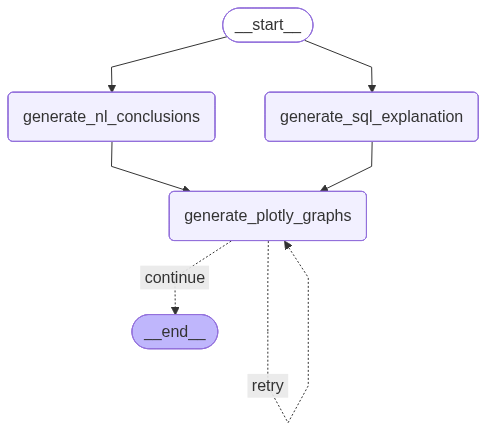

In [21]:
workflow = StateGraph(
    state_schema= ConclusionsGeneratorState,
    input_schema= ConclusionsGeneratorState,
    output_schema= ConclusionsGeneratorOutputState,
)

workflow.add_node('generate_nl_conclusions', nl_conclusions_generation_node)
workflow.add_node('generate_sql_explanation', sql_query_explanation_node)
workflow.add_node('generate_plotly_graphs', graphs_generation_node)

workflow.add_edge(START, 'generate_nl_conclusions')
workflow.add_edge(START, 'generate_sql_explanation')
workflow.add_edge('generate_nl_conclusions', 'generate_plotly_graphs')
workflow.add_edge('generate_sql_explanation', 'generate_plotly_graphs')
workflow.add_conditional_edges(
    'generate_plotly_graphs',
    lambda state: (
        'retry'
        if state.get('graphics_json') is None 
        and state.get('graphs_retries', 0) < MAX_RETRIES
        else 'continue'
    ),
    {
        'retry': 'generate_plotly_graphs',
        'continue': END
    }
)

conclusions_generator = workflow.compile()

Image(conclusions_generator.get_graph().draw_mermaid_png())

## 8. Ejemplos

In [22]:
response = conclusions_generator.invoke({
    'user_query': user_query,
    'language': 'Spanish',
    'sql_query': sql_query,
    'query_results': query_results,
})

response


--- INICIANDO GENERACIÓN DE CONCLUSIONES 📝 ---

--- INICIANDO EXPLICACIÓN DE CONSULTA SQL 🗂️ ---

--- INICIANDO GENERACIÓN DE GRÁFICOS 📊 ---


{'nl_output': '1. La camiseta clásica (talla P) lidera en pedidos con promociones, acumulando un total de 951 unidades en tres meses.  \n2. Los jerseys clásicos de manga corta (talla SG) ocupan el segundo lugar con 811 unidades totales.  \n3. Los pantalones cortos Women\'s Mountain Shorts (talla S) registran 694 unidades, destacándose en la categoría de prendas inferiores.  \n4. El jersey con logotipo de manga larga (talla G) alcanza 684 unidades, siendo el segundo producto más solicitado en la subcategoría de jerseys.  \n5. La gorra AWC Logo Cap acumula 655 unidades, posicionándose como el accesorio más demandado.  \n6. Los pantalones cortos Women\'s Mountain Shorts (talla L) suman 618 unidades, mostrando consistencia en la demanda por tallas grandes.  \n7. Los calcetines para carreras (talla G) registran 503 unidades, liderando en la subcategoría de calcetines.  \n8. La camiseta clásica (talla M) acumula 469 unidades, siendo la segunda talla más solicitada en esta subcategoría.  \n9.

In [23]:
print(response['nl_output'])

1. La camiseta clásica (talla P) lidera en pedidos con promociones, acumulando un total de 951 unidades en tres meses.  
2. Los jerseys clásicos de manga corta (talla SG) ocupan el segundo lugar con 811 unidades totales.  
3. Los pantalones cortos Women's Mountain Shorts (talla S) registran 694 unidades, destacándose en la categoría de prendas inferiores.  
4. El jersey con logotipo de manga larga (talla G) alcanza 684 unidades, siendo el segundo producto más solicitado en la subcategoría de jerseys.  
5. La gorra AWC Logo Cap acumula 655 unidades, posicionándose como el accesorio más demandado.  
6. Los pantalones cortos Women's Mountain Shorts (talla L) suman 618 unidades, mostrando consistencia en la demanda por tallas grandes.  
7. Los calcetines para carreras (talla G) registran 503 unidades, liderando en la subcategoría de calcetines.  
8. La camiseta clásica (talla M) acumula 469 unidades, siendo la segunda talla más solicitada en esta subcategoría.  
9. Los guantes Half-Finger 

In [24]:
print(response['sql_explanation'])

## Análisis de la Lógica de la Consulta

La consulta identifica los productos más vendidos en el último trimestre (excluyendo accesorios) dentro de las ventas realizadas por revendedores. Primero, se filtran las ventas del último trimestre y se excluyen los productos categorizados como "Accesorio". Luego, se agrupan los datos por producto para calcular la cantidad total vendida y se seleccionan los 10 productos con mayor volumen de ventas. Finalmente, se analiza la distribución de las ventas de estos productos por mes dentro del trimestre, mostrando las cantidades vendidas en cada mes y el total acumulado.

## Conclusión y Resultados Clave

La consulta genera un informe que detalla los 10 productos más vendidos en el último trimestre, junto con su categoría y subcategoría. Además, desglosa las ventas mensuales dentro del trimestre y calcula el total acumulado. Esto permite identificar patrones de demanda y evaluar el rendimiento de los productos más populares en el contexto de las prom

In [25]:
create_dashboard_from_json(response['graphics_json'])